In [1]:
import numpy as np 
import pandas as pd 
import itertools
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from glob import glob
from skimage import io
from os import listdir
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from keras.models import load_model
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
imagePatches = glob('./IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

./IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print("IDC(-)\n\n",classZero[0:2],'\n')
print("IDC(+)\n\n",classOne[0:2])

IDC(-)

 ['./IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png', './IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png'] 

IDC(+)

 ['./IDC_regular_ps50_idx5/9036/1/9036_idx5_x1851_y1351_class1.png', './IDC_regular_ps50_idx5/9036/1/9036_idx5_x1851_y1451_class1.png']


In [4]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    channels = 3
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [5]:
X,Y = proc_images(0,278000)

In [6]:
X=np.array(X)
X= X.astype(np.float32)
X/=255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=1984)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (249771, 50, 50, 3)
Testing Data Shape: (27753, 50, 50, 3)


In [7]:
Y_train.count(0), Y_train.count(1)

(178852, 70919)

In [8]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [36]:
X_train.shape[2]

50

In [9]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [10]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler()
X_trainRus, Y_trainRus = random_under_sampler.fit_sample(X_trainFlat, Y_train)
X_testRus, Y_testRus = random_under_sampler.fit_sample(X_testFlat, Y_test)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [11]:
Y_trainRusHot = to_categorical(Y_trainRus, num_classes=2)
Y_testRusHot = to_categorical(Y_testRus, num_classes=2)

In [12]:
np.unique(Y_trainRus, return_counts=True)

(array([0, 1]), array([70919, 70919]))

In [13]:
for i in range(len(X_trainRus)):
    height, width, channels = 50, 50, 3
    X_trainRusReshaped = X_trainRus.reshape(len(X_trainRus), height, width, channels)

In [14]:
for i in range(len(X_testRus)):
    height, width, channels = 50, 50, 3
    X_testRusReshaped = X_testRus.reshape(len(X_testRus), height, width, channels)

In [15]:
batch_size = 512
num_classes = 2
epochs = 30
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [16]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 512)        

In [18]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True) 

In [19]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [20]:
history = model.fit_generator(datagen.flow(X_trainRusReshaped,Y_trainRusHot,batch_size=batch_size),
                steps_per_epoch=len(X_trainRusReshaped) / batch_size, epochs=epochs,validation_data=(X_testRusReshaped, Y_testRusHot),
                verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])

Epoch 1/30
278/277 [==============================] - 393s 1s/step - loss: 0.6592 - accuracy: 0.6065 - val_loss: 0.5148 - val_accuracy: 0.7761

Epoch 00001: val_loss improved from inf to 0.51477, saving model to best_model.h5
Epoch 2/30


/Applications/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


278/277 [==============================] - 380s 1s/step - loss: 0.5241 - accuracy: 0.7826 - val_loss: 0.4720 - val_accuracy: 0.7848

Epoch 00002: val_loss improved from 0.51477 to 0.47197, saving model to best_model.h5
Epoch 3/30
278/277 [==============================] - 379s 1s/step - loss: 0.4901 - accuracy: 0.7959 - val_loss: 0.4491 - val_accuracy: 0.7898

Epoch 00003: val_loss improved from 0.47197 to 0.44906, saving model to best_model.h5
Epoch 4/30
278/277 [==============================] - 399s 1s/step - loss: 0.4642 - accuracy: 0.8077 - val_loss: 0.4057 - val_accuracy: 0.8232

Epoch 00004: val_loss improved from 0.44906 to 0.40566, saving model to best_model.h5
Epoch 5/30
278/277 [==============================] - 391s 1s/step - loss: 0.4517 - accuracy: 0.8152 - val_loss: 0.4173 - val_accuracy: 0.8133

Epoch 00005: val_loss did not improve from 0.40566
Epoch 6/30
278/277 [==============================] - 376s 1s/step - loss: 0.4371 - accuracy: 0.8232 - val_loss: 0.4202 - val_

In [21]:
score = model.evaluate(X_testRusReshaped, Y_testRusHot, verbose=0)
y_pred = model.predict(X_testRusReshaped)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('CNN Accuracy Score', score[1],'\n')
print('\n', sklearn.metrics.classification_report(np.where(Y_testRusHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')


CNN Accuracy Score 0.852929949760437 


              precision    recall  f1-score   support

      IDC(-)       0.91      0.78      0.84      7867
      IDC(+)       0.81      0.92      0.86      7867

    accuracy                           0.85     15734
   macro avg       0.86      0.85      0.85     15734
weighted avg       0.86      0.85      0.85     15734



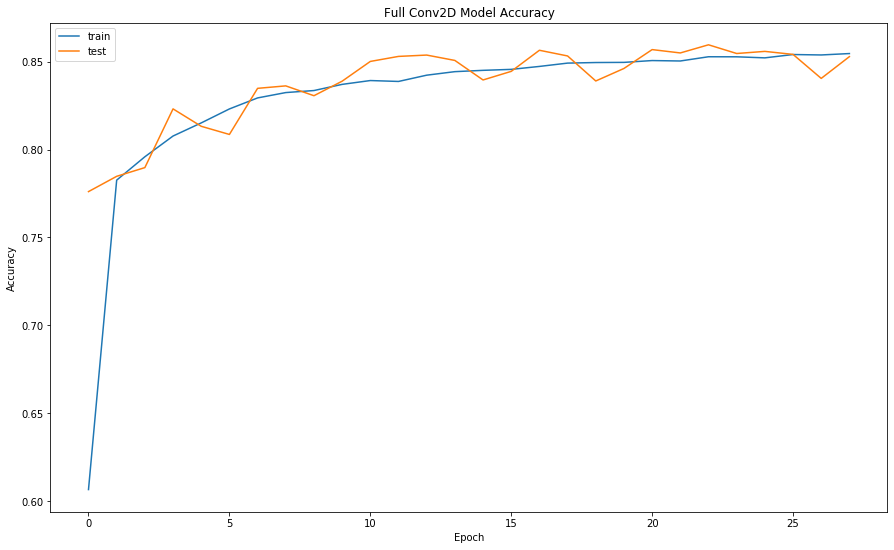

In [25]:
plt.figure(figsize=(15,9))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Full Conv2D Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

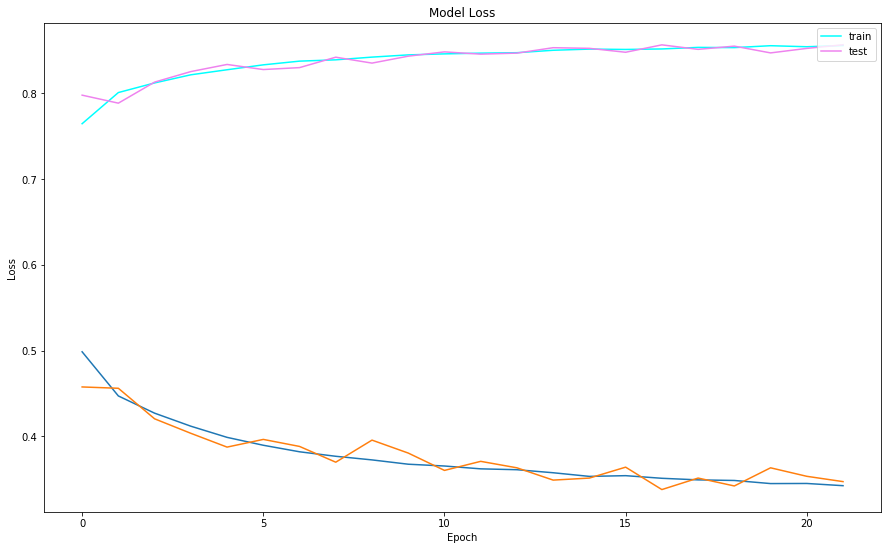

In [25]:
plt.figure(figsize=(15,9))
plt.plot(history.history['accuracy'], color='cyan')
plt.plot(history.history['val_accuracy'], color='violet')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Full')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)
y_true_labels = np.argmax(Y_testRusHot,axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

In [38]:
model = load_model('best_model.h5')

preds = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(preds, axis = 1)

y_true_labels = np.argmax(Y_testRusHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[6593 1274]
 [ 934 6933]]


In [49]:
preds

array([[0.9746208 , 0.02506059],
       [0.97701275, 0.02278483],
       [0.38747153, 0.6134969 ],
       ...,
       [0.56684154, 0.4368201 ],
       [0.26279867, 0.7358743 ],
       [0.03667714, 0.96294326]], dtype=float32)

In [50]:
y_pred_labels[:3]

array([0, 0, 1])

In [55]:
model = Sequential()
model.add(Flatten(input_shape=(50,50,3)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 7500)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.add(Dense(128, activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               960128    
_________________________________________________________________
dense_8 (Dense)              (None, 132)               17028     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 266       
Total params: 977,422
Trainable params: 977,422
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [67]:
history = model.fit(X_trainRusReshaped,
                    Y_trainRusHot,
                    batch_size=256,
                    validation_data=(X_testRusReshaped, Y_testRusHot),
                    epochs=10,
                    verbose=1)

Train on 141838 samples, validate on 15734 samples
Epoch 1/10
141838/141838 [==============================] - 11s 79us/step - loss: 0.5302 - accuracy: 0.7486 - val_loss: 0.5131 - val_accuracy: 0.7585
Epoch 2/10
141838/141838 [==============================] - 7s 50us/step - loss: 0.4804 - accuracy: 0.7799 - val_loss: 0.4619 - val_accuracy: 0.7930
Epoch 3/10
141838/141838 [==============================] - 7s 50us/step - loss: 0.4733 - accuracy: 0.7839 - val_loss: 0.4999 - val_accuracy: 0.7715
Epoch 4/10
141838/141838 [==============================] - 7s 50us/step - loss: 0.4702 - accuracy: 0.7852 - val_loss: 0.4899 - val_accuracy: 0.7761
Epoch 5/10
141838/141838 [==============================] - 7s 50us/step - loss: 0.4657 - accuracy: 0.7873 - val_loss: 0.4804 - val_accuracy: 0.7826
Epoch 6/10
141838/141838 [==============================] - 7s 50us/step - loss: 0.4625 - accuracy: 0.7887 - val_loss: 0.4782 - val_accuracy: 0.7837
Epoch 7/10
141838/141838 [============================

In [70]:
score = model.evaluate(X_testRusReshaped, Y_testRusHot, verbose=0)
y_pred = model.predict(X_testRusReshaped)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('Feed Forward Accuracy Score', score[1],'\n')
print('\n', sklearn.metrics.classification_report(np.where(Y_testRusHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')


Feed Forward Accuracy Score 0.7989068031311035 


              precision    recall  f1-score   support

      IDC(-)       0.79      0.82      0.80      7867
      IDC(+)       0.81      0.78      0.79      7867

    accuracy                           0.80     15734
   macro avg       0.80      0.80      0.80     15734
weighted avg       0.80      0.80      0.80     15734



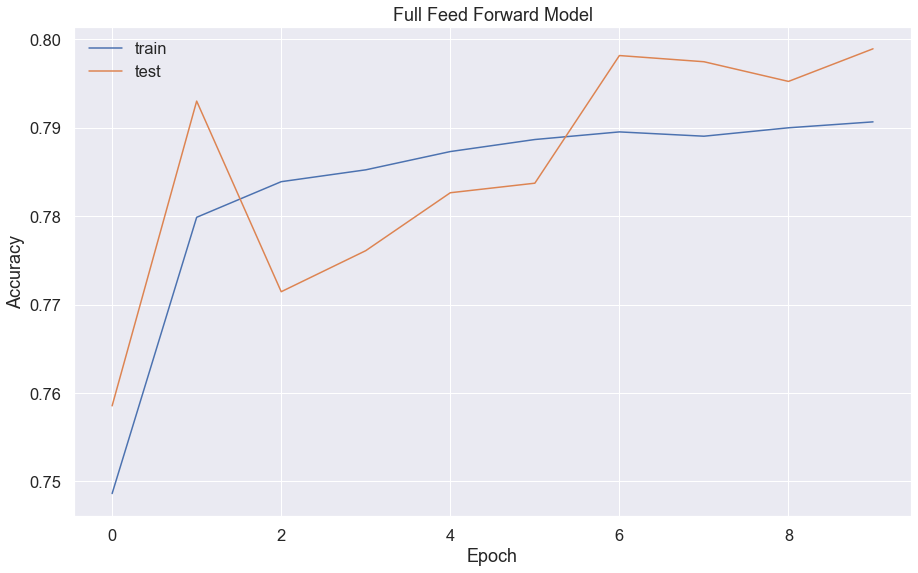

In [69]:
plt.figure(figsize=(15,9))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Full Feed Forward Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

In [71]:
y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)
y_true_labels = np.argmax(Y_testRusHot,axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[6444 1423]
 [1741 6126]]


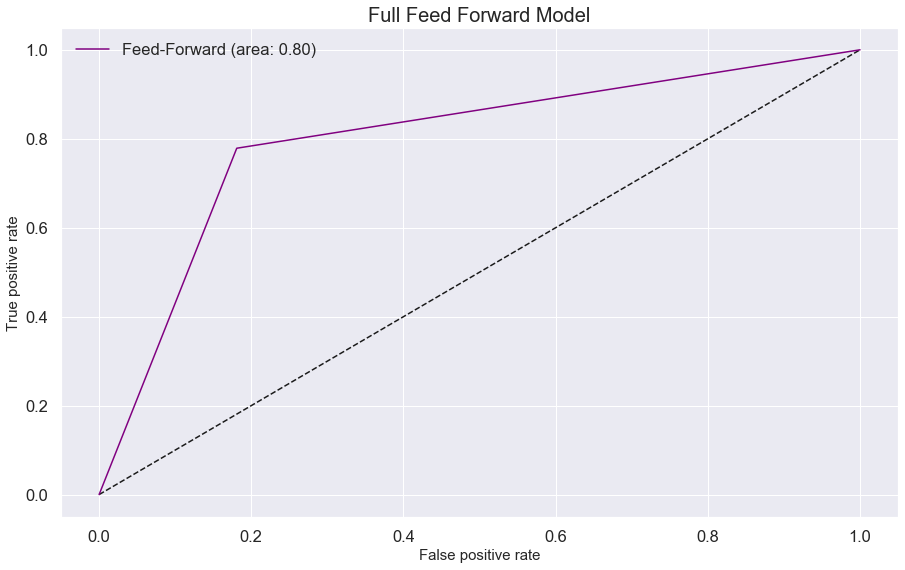

In [73]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)

plt.figure(figsize = (15,9))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Feed-Forward (area: %0.2f)'
             % auc(fpr,tpr), color = "purple")
plt.xlabel('False positive rate', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.title('Full Feed Forward Model', fontsize = 20)
plt.legend(loc='best')
plt.show()

In [76]:
X_train[:1]

array([[[[0.8039216 , 0.7529412 , 0.9137255 ],
         [0.8117647 , 0.73333335, 0.91764706],
         [0.6784314 , 0.5686275 , 0.8117647 ],
         ...,
         [0.4627451 , 0.32156864, 0.8       ],
         [0.52156866, 0.36862746, 0.8       ],
         [0.50980395, 0.38039216, 0.8117647 ]],

        [[0.91764706, 0.9019608 , 0.9254902 ],
         [0.8862745 , 0.84313726, 0.94509804],
         [0.62352943, 0.49019608, 0.8156863 ],
         ...,
         [0.4509804 , 0.31764707, 0.78431374],
         [0.4862745 , 0.32941177, 0.7921569 ],
         [0.5411765 , 0.38431373, 0.8156863 ]],

        [[0.91764706, 0.9019608 , 0.93333334],
         [0.9098039 , 0.88235295, 0.9372549 ],
         [0.6117647 , 0.46666667, 0.8       ],
         ...,
         [0.5058824 , 0.34901962, 0.7882353 ],
         [0.5019608 , 0.3764706 , 0.7921569 ],
         [0.5294118 , 0.3529412 , 0.73333335]],

        ...,

        [[0.44313726, 0.24313726, 0.39607844],
         [0.50980395, 0.31764707, 0.5803922 ]

In [78]:
y_pred_labels

array([0, 0, 1, ..., 1, 1, 1])

In [79]:
y_true_labels

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('InceptionV3_second_model.h5')